In [8]:
import json
import math

def load_elements(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)["elements"]

def is_same_id(a, b):
    return a["id"] == b["id"]

def is_position_changed(pos_a, pos_b, tolerance=10):
    dx = abs(pos_a["x"] - pos_b["x"])
    dy = abs(pos_a["y"] - pos_b["y"])
    return dx > tolerance or dy > tolerance

def compare_elements(base_elements, new_elements):
    diffs = []
    base_dict = {e["id"]: e for e in base_elements}
    new_dict = {e["id"]: e for e in new_elements}

    # ➖ 삭제됨
    for eid in base_dict:
        if eid not in new_dict:
            diffs.append({
                "id": eid,
                "changeType": "removed",
                "position": base_dict[eid]["position"]
            })

    # ➕ 추가됨 또는 🔁 변경됨
    for eid, new_elem in new_dict.items():
        if eid not in base_dict:
            diffs.append({
                "id": eid,
                "changeType": "added",
                "position": new_elem["position"]
            })
        else:
            old_elem = base_dict[eid]
            if is_position_changed(old_elem["position"], new_elem["position"]):
                diffs.append({
                    "id": eid,
                    "changeType": "moved",
                    "from": old_elem["position"],
                    "to": new_elem["position"]
                })

    return diffs

def run_diff(base_path, new_path, output_path="diff_result.json"):
    base = load_elements(base_path)
    new = load_elements(new_path)

    result = {
        "diffs": compare_elements(base, new)
    }

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2)
    print(f"✅ 변경 사항 저장됨: {output_path}")

# 예시 실행
if __name__ == "__main__":
    run_diff(
        base_path="standardized_elements_org.json",
        new_path="standardized_elements_org2.json",
        output_path="diff_result.json"
    )


✅ 변경 사항 저장됨: diff_result.json


In [2]:
import json
from PIL import Image, ImageDraw, ImageFont

def visualize_diff(image_path, diff_json_path, output_path="diff_visualization.png"):
    # 이미지 열기
    img = Image.open(image_path).convert("RGBA")
    draw = ImageDraw.Draw(img)

    # 폰트 설정 (선택적)
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = None  # 시스템 기본

    # 변경사항 로딩
    with open(diff_json_path, "r", encoding="utf-8") as f:
        diff_data = json.load(f)

    for diff in diff_data["diffs"]:
        change_type = diff["changeType"]
        color = "gray"
        label = diff["id"]

        if change_type == "added":
            pos = diff["position"]
            color = "green"
            draw.rectangle(
                [(pos["x"] - pos["width"]/2, pos["y"] - pos["height"]/2),
                 (pos["x"] + pos["width"]/2, pos["y"] + pos["height"]/2)],
                outline=color, width=3
            )
            draw.text((pos["x"], pos["y"] - 20), f"NEW: {label}", fill=color, font=font)

        elif change_type == "removed":
            pos = diff["position"]
            color = "gray"
            draw.rectangle(
                [(pos["x"] - pos["width"]/2, pos["y"] - pos["height"]/2),
                 (pos["x"] + pos["width"]/2, pos["y"] + pos["height"]/2)],
                outline=color, width=3
            )
            draw.text((pos["x"], pos["y"] - 20), f"DEL: {label}", fill=color, font=font)

        elif change_type == "moved":
            from_pos = diff["from"]
            to_pos = diff["to"]
            draw.rectangle(
                [(from_pos["x"] - from_pos["width"]/2, from_pos["y"] - from_pos["height"]/2),
                 (from_pos["x"] + from_pos["width"]/2, from_pos["y"] + from_pos["height"]/2)],
                outline="red", width=2
            )
            draw.rectangle(
                [(to_pos["x"] - to_pos["width"]/2, to_pos["y"] - to_pos["height"]/2),
                 (to_pos["x"] + to_pos["width"]/2, to_pos["y"] + to_pos["height"]/2)],
                outline="orange", width=3
            )
            draw.text((to_pos["x"], to_pos["y"] - 20), f"MOVED: {label}", fill="orange", font=font)

    # 결과 저장
    img.save(output_path)
    print(f"✅ 변경사항 시각화 완료: {output_path}")

# 예시 실행
if __name__ == "__main__":
    visualize_diff(
        image_path="org.png",
        diff_json_path="diff_result.json",
        output_path="diff_visualization.png"
    )


✅ 변경사항 시각화 완료: diff_visualization.png


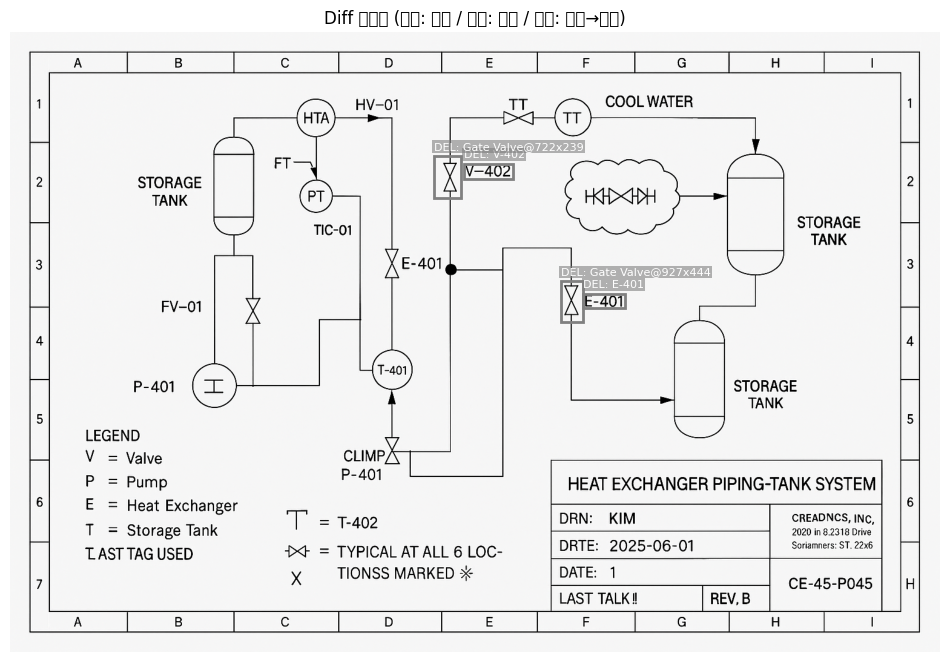

In [10]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_diff_boxes(image_path, diff_json_path):
    img = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img)

    with open(diff_json_path, "r", encoding="utf-8") as f:
        diff_data = json.load(f)

    for diff in diff_data["diffs"]:
        change_type = diff["changeType"]
        label = diff["id"]

        if change_type == "added":
            pos = diff["position"]
            box = _to_box_polygon(pos)
            color = "green"
            _draw_patch(ax, box, label, color, prefix="NEW")

        elif change_type == "removed":
            pos = diff["position"]
            box = _to_box_polygon(pos)
            color = "gray"
            _draw_patch(ax, box, label, color, prefix="DEL")

        elif change_type == "moved":
            from_pos = diff["from"]
            to_pos = diff["to"]

            from_box = _to_box_polygon(from_pos)
            to_box = _to_box_polygon(to_pos)

            _draw_patch(ax, from_box, label, "red", prefix="FROM")
            _draw_patch(ax, to_box, label, "orange", prefix="TO")

    plt.axis("off")
    plt.title("Diff 시각화 (추가: 초록 / 삭제: 회색 / 이동: 빨강→주황)")
    plt.show()

def _to_box_polygon(pos):
    x, y, w, h = pos["x"], pos["y"], pos["width"], pos["height"]
    return [
        (x - w/2, y - h/2),
        (x + w/2, y - h/2),
        (x + w/2, y + h/2),
        (x - w/2, y + h/2)
    ]

def _draw_patch(ax, box, label, color, prefix=""):
    poly = patches.Polygon(box, closed=True, fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(poly)
    ax.text(
        box[0][0], box[0][1] - 10,
        f"{prefix}: {label}",
        fontsize=8, color='white',
        bbox=dict(facecolor=color, edgecolor='none', alpha=0.6, pad=1)
    )

# 예시 실행
if __name__ == "__main__":
    draw_diff_boxes("org.png", "diff_result.json")
